Extracting EDF parameters from c:\Users\HP\Desktop\session2\Person9\B0901T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\HP\AppData\Local\Temp\ipykernel_1096\2506471477.py:14: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path, preload=True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 176 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\HP\Desktop\session2\Person9\B0902T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\HP\AppData\Local\Temp\ipykernel_1096\2506471477.py:14: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf(file_path, preload=True)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 176 original time points ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 7.9e-07 (2.2e-16 eps * 3 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-07 (2.2e-16 eps * 3 dim * 1.2e+09  max singular value)
    Estimated rank (mag): 

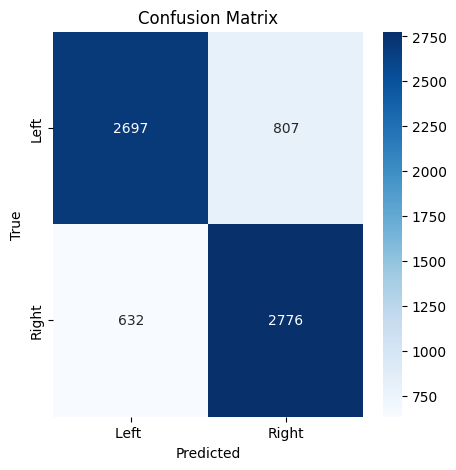

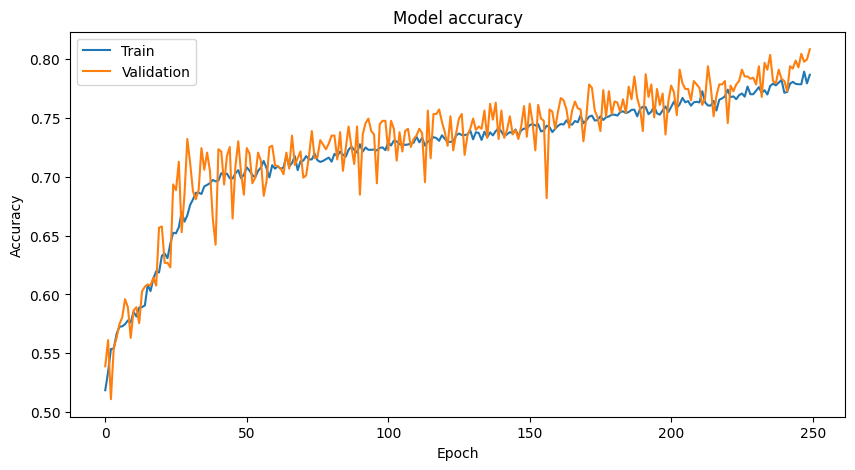

In [2]:
import numpy as np
import mne
from mne.decoding import CSP
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns


# Function to preprocess data and extract specific events
def preprocess_data(file_path, event_ids):
    raw = mne.io.read_raw_gdf(file_path, preload=True)
    raw.set_eeg_reference()

    # Select EEG channels and create epochs
    desired_channels = ['EEG:C3', 'EEG:Cz', 'EEG:C4']
    raw.pick_channels(desired_channels)
    events, _ = mne.events_from_annotations(raw)
    epochs = mne.Epochs(raw, events, event_id=event_ids, on_missing='warn')
    labels = epochs.events[:, -1]
    data = epochs.get_data()

    return data, labels

# File paths and corresponding event IDs
file_paths = ["Person9\B0901T.gdf", "Person9\B0902T.gdf"]
event_ids_list = [{'T0': 10, 'T1': 11}, {'T0': 10, 'T1': 11}]

# Lists to store preprocessed data and labels
all_data = []
all_labels = []

# Preprocess data from each file and extract specific events
for file_path, event_ids in zip(file_paths, event_ids_list):
    data, labels = preprocess_data(file_path, event_ids)
    all_data.append(data)
    all_labels.append(labels)

# Concatenate the data and labels arrays from all files
merged_data = np.concatenate(all_data, axis=0)
merged_labels = np.concatenate(all_labels, axis=0)

# Parameters
n_channels = merged_data.shape[1]
window_size = 200
step_size = 5

# Frequency bands
frequency_bands = [(2, 6), (6, 10), (10, 14), (14, 18),
                   (18, 22), (22, 26), (26, 30), (30, 34)]

# Extract CSP features for each frequency band
X_band = []  # List to store features
y_band = []  # List to store labels

for band_idx, (fmin, fmax) in enumerate(frequency_bands):
    for t_start in range(0, merged_data.shape[0] - window_size + 1, step_size):
        t_end = t_start + window_size
        X_window = merged_data[:, :, t_start:t_end]
        y_window = merged_labels

        csp = CSP(n_components=10, transform_into='average_power')
        csp.fit(X_window, y_window)
        X_band.append(csp.transform(X_window))
        y_band.extend(y_window)

# Convert lists to numpy arrays
X_band = np.concatenate(X_band, axis=0)
y_band = np.array(y_band)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_band, y_band, test_size=0.4, random_state=42)

input_shape = (3,1)

model = keras.Sequential()
model.add(layers.Reshape((3, 1), input_shape=input_shape))  # Reshape the input to (3, 1) for 1D convolution
model.add(layers.Conv1D(16, kernel_size=3, activation='relu', padding='same'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))  # Adjust units to match the number of classes

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

y_train_processed = y_train - 10  # Map 10 to 0 and 11 to 1
y_test_processed = y_test - 10

history = model.fit(X_train, y_train_processed, epochs=250, batch_size=32, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_processed)

# Predict labels for the test set
predicted_labels = model.predict(X_test)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_processed, predicted_labels)

# Calculate overall accuracy
accuracy = accuracy_score(y_test_processed, predicted_labels)

# Calculate Cohen's Kappa score
kappa = cohen_kappa_score(y_test_processed, predicted_labels)

# Print accuracy and kappa score
print(f"Test accuracy: {accuracy}")
print(f"Cohen's Kappa score: {kappa}")

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Left ', 'Right'], yticklabels=['Left', 'Right'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



Test accuracy: 0.7918113425925926
Cohen's Kappa score: 0.5838350893118947
              precision    recall  f1-score   support

          T0       0.81      0.77      0.79      3504
          T1       0.77      0.81      0.79      3408

    accuracy                           0.79      6912
   macro avg       0.79      0.79      0.79      6912
weighted avg       0.79      0.79      0.79      6912



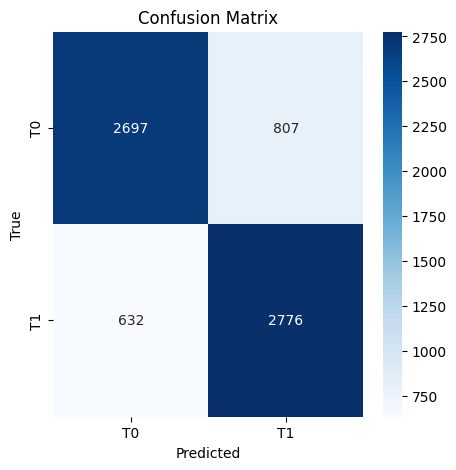

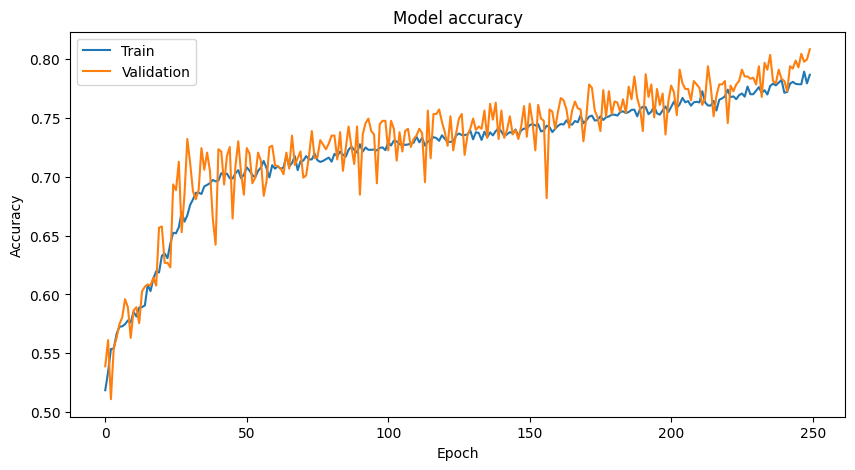

In [3]:
# ... (your previous code)

# Print accuracy and kappa score
print(f"Test accuracy: {accuracy}")
print(f"Cohen's Kappa score: {kappa}")

# Classification Report
from sklearn.metrics import classification_report
class_names = ['T0', 'T1']  # Replace these with actual class names if different
print(classification_report(y_test_processed, predicted_labels, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
